In [1]:
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from os import makedirs, listdir
import tensorflow.keras.callbacks

from shutil import copyfile
from random import seed, random

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from os import listdir

import sys
import time

# import cv2

In [2]:
model_data = {
    'VGG1': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    },
    'VGG3': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    },
    'VGG3DA': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    },
    'VGG16TL': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    }
}


In [3]:
def VGG1():
	# define cnn model
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

def VGG3():
	# define cnn model
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# VGG3 with Data Augmentation
def VGG3_DA():
	# define cnn model
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# define cnn transfer learning with VGG16 model
def VGG16_TL():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [4]:
# FOR VGG1, VGG3
def prepare_iterators_VGG():
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/train/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/test/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	return train_it, test_it

def prepare_iterators_VGG3_DA():
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/train/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/test/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	return train_it, test_it

def prepare_iterators_TL():
	#create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	datagen.mean = [123.68, 116.779, 103.939]

	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/train/', class_mode='binary', batch_size=32, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/test/', class_mode='binary', batch_size=32, target_size=(224, 224))
	return train_it, test_it

In [5]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # create figure and axes objects
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    plt.subplots_adjust(hspace=0.5)

    # plot loss
    axs[0].set_title('Cross Entropy Loss')
    axs[0].plot(history.history['loss'], color='blue', label='train')
    axs[0].plot(history.history['val_loss'], color='orange', label='test')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')

    # plot accuracy
    axs[1].set_title('Classification Accuracy')
    axs[1].plot(history.history['accuracy'], color='blue', label='train')
    axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')

    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    # plt.savefig(filename + '_plot.png')
    plt.show()

In [6]:
model_VGG1 = VGG1()
model_VGG3 = VGG3()
# Iterators for VGG 1, VGG3
train_it, test_it = prepare_iterators_VGG()


# VGG 3 with Data Augmentation
model_VGG3_DA = VGG3_DA()
train_it_da, test_it_da = prepare_iterators_VGG3_DA()

# VGG16 Transfer Learning
model_VGG16_TL = VGG16_TL()
train_it_tl, test_it_tl = prepare_iterators_TL()

Metal device set to: Apple M1
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# VGG1

In [7]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG1", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20


2023-04-19 15:33:28.643537: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 17s 4s/step - loss: 1.2047 - accuracy: 0.4875 - val_loss: 0.7312 - val_accuracy: 0.3750
Epoch 2/20
5/5 [==============================] - 15s 3s/step - loss: 0.7258 - accuracy: 0.5375 - val_loss: 0.6690 - val_accuracy: 0.6250
Epoch 3/20
5/5 [==============================] - 15s 4s/step - loss: 0.6881 - accuracy: 0.5250 - val_loss: 0.7727 - val_accuracy: 0.3750
Epoch 4/20
5/5 [==============================] - 15s 4s/step - loss: 0.6512 - accuracy: 0.6062 - val_loss: 0.6760 - val_accuracy: 0.5750
Epoch 5/20
5/5 [==============================] - 15s 4s/step - loss: 0.6285 - accuracy: 0.6687 - val_loss: 0.7680 - val_accuracy: 0.4000
Epoch 6/20
5/5 [==============================] - 15s 4s/step - loss: 0.6214 - accuracy: 0.6625 - val_loss: 0.6385 - val_accuracy: 0.6500
Epoch 7/20
5/5 [==============================] - 15s 3s/step - loss: 0.5955 - accuracy: 0.6938 - val_loss: 0.7743 - val_accuracy: 0.4000
Epoch 8/20
5/5 [=============================

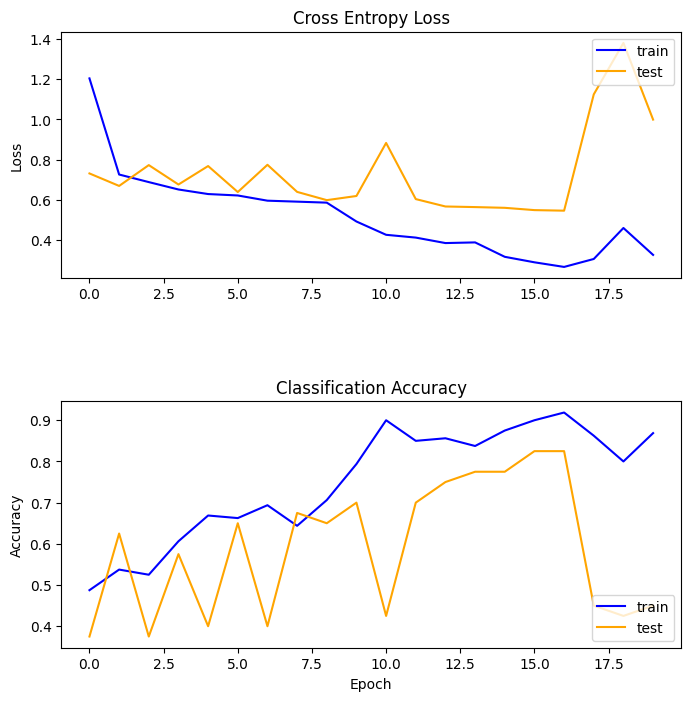

> 45.000


In [8]:
begin_time = time.time()
history, train_it, test_it = fit_model_evaluate(model_VGG1, train_it, test_it)
end_time = time.time()

# evaluate model
summarize_diagnostics(history)
# accuracy
_, acc = model_VGG1.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


In [9]:
training_loss=history.history['loss'][-1]
training_acc=history.history['accuracy'][-1]
testing_acc=history.history['val_accuracy'][-1]
number_of_parameters=model_VGG1.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG1']['Trainingtime'] = (training_time)
model_data['VGG1']['Trainingloss'] = (training_loss)
model_data['VGG1']['Trainingaccuracy'] = (training_acc)
model_data['VGG1']['Testingaccuracy'] = (testing_acc)
model_data['VGG1']['Numberofmodelparameters'] = (number_of_parameters)
print(model_data)


Training Loss:  0.32540035247802734
Training Accuracy:  0.8687499761581421
Testing Accuracy:  0.44999998807907104
Number of Parameters:  40961153
Training Time:  302.301696062088
{'VGG1': {'Trainingtime': 302.301696062088, 'Trainingloss': 0.32540035247802734, 'Trainingaccuracy': 0.8687499761581421, 'Testingaccuracy': 0.44999998807907104, 'Numberofmodelparameters': 40961153}, 'VGG3': {'Trainingtime': None, 'Trainingloss': None, 'Trainingaccuracy': None, 'Testingaccuracy': None, 'Numberofmodelparameters': None}, 'VGG3DA': {'Trainingtime': None, 'Trainingloss': None, 'Trainingaccuracy': None, 'Testingaccuracy': None, 'Numberofmodelparameters': None}, 'VGG16TL': {'Trainingtime': None, 'Trainingloss': None, 'Trainingaccuracy': None, 'Testingaccuracy': None, 'Numberofmodelparameters': None}}


# VGG3

In [10]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG3", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 6s 1s/step - loss: 0.9707 - accuracy: 0.3500 - val_loss: 0.7309 - val_accuracy: 0.3750
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 0.7794 - accuracy: 0.5375 - val_loss: 0.6688 - val_accuracy: 0.5750
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 0.6756 - accuracy: 0.5562 - val_loss: 0.6667 - val_accuracy: 0.6000
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 0.6367 - accuracy: 0.6750 - val_loss: 0.7108 - val_accuracy: 0.4250
Epoch 5/20
5/5 [==============================] - 5s 1s/step - loss: 0.6123 - accuracy: 0.7312 - val_loss: 0.6554 - val_accuracy: 0.6000
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 0.5891 - accuracy: 0.7312 - val_loss: 0.6542 - val_accuracy: 0.6250
Epoch 7/20
5/5 [==============================] - 5s 1s/step - loss: 0.5656 - accuracy: 0.7188 - val_loss: 0.6368 - val_accuracy: 0.6000
Epoch 8/20
5/5 [=========================

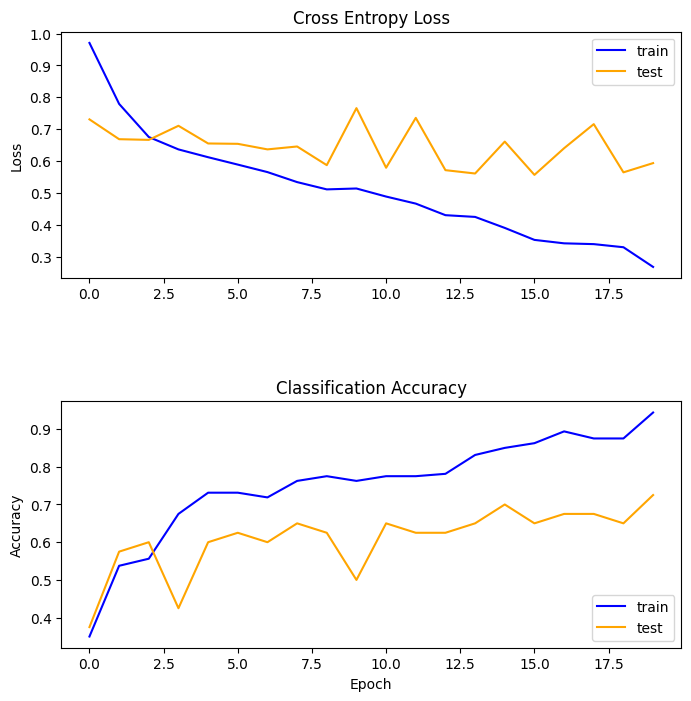

> 72.500


In [11]:
begin_time = time.time()
history2, train_it, test_it = fit_model_evaluate(model_VGG3, train_it, test_it)
end_time = time.time()

# evaluate model
summarize_diagnostics(history2)
# accuracy
_, acc = model_VGG3.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


In [12]:
training_loss=history2.history['loss'][-1]
training_acc=history2.history['accuracy'][-1]
testing_acc=history2.history['val_accuracy'][-1]
number_of_parameters=model_VGG3.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG3']['Trainingtime'] = (training_time)
model_data['VGG3']['Trainingloss'] = (training_loss)
model_data['VGG3']['Trainingaccuracy'] = (training_acc)
model_data['VGG3']['Testingaccuracy'] = (testing_acc)
model_data['VGG3']['Numberofmodelparameters'] = (number_of_parameters)

print(model_data)


Training Loss:  0.26818832755088806
Training Accuracy:  0.9437500238418579
Testing Accuracy:  0.7250000238418579
Number of Parameters:  10333505
Training Time:  105.62922811508179
{'VGG1': {'Trainingtime': 302.301696062088, 'Trainingloss': 0.32540035247802734, 'Trainingaccuracy': 0.8687499761581421, 'Testingaccuracy': 0.44999998807907104, 'Numberofmodelparameters': 40961153}, 'VGG3': {'Trainingtime': 105.62922811508179, 'Trainingloss': 0.26818832755088806, 'Trainingaccuracy': 0.9437500238418579, 'Testingaccuracy': 0.7250000238418579, 'Numberofmodelparameters': 10333505}, 'VGG3DA': {'Trainingtime': None, 'Trainingloss': None, 'Trainingaccuracy': None, 'Testingaccuracy': None, 'Numberofmodelparameters': None}, 'VGG16TL': {'Trainingtime': None, 'Trainingloss': None, 'Trainingaccuracy': None, 'Testingaccuracy': None, 'Numberofmodelparameters': None}}


# VGG3 with Data Augmentation

In [13]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG3_DA", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 7s 2s/step - loss: 2.1357 - accuracy: 0.4062 - val_loss: 0.6800 - val_accuracy: 0.6000
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 0.7011 - accuracy: 0.4875 - val_loss: 0.7134 - val_accuracy: 0.4250
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 0.7015 - accuracy: 0.4750 - val_loss: 0.7137 - val_accuracy: 0.3750
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 0.6973 - accuracy: 0.5312 - val_loss: 0.7211 - val_accuracy: 0.3750
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 0.7102 - accuracy: 0.4250 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 0.7147 - accuracy: 0.5500 - val_loss: 0.7351 - val_accuracy: 0.3750
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 0.6654 - accuracy: 0.5562 - val_loss: 0.6560 - val_accuracy: 0.6500
Epoch 8/20
5/5 [=========================

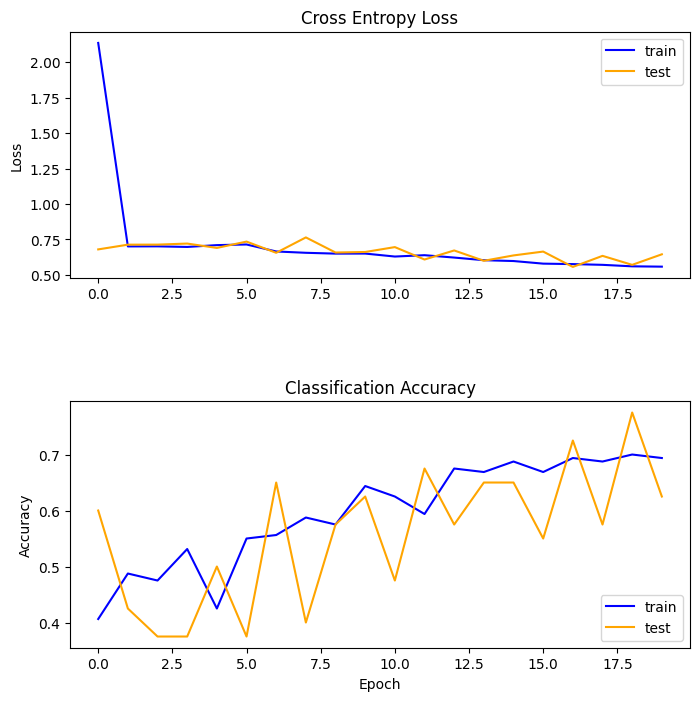

> 55.000


In [14]:
begin_time = time.time()
history3, train_it, test_it = fit_model_evaluate(model_VGG3_DA, train_it_da, test_it_da)
end_time = time.time()

# evaluate model
summarize_diagnostics(history3)
# accuracy
_, acc = model_VGG3.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


In [15]:
training_loss=history3.history['loss'][-1]
training_acc=history3.history['accuracy'][-1]
testing_acc=history3.history['val_accuracy'][-1]
number_of_parameters=model_VGG3_DA.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG3DA']['Trainingtime'] = (training_time)
model_data['VGG3DA']['Trainingloss'] = (training_loss)
model_data['VGG3DA']['Trainingaccuracy'] = (training_acc)
model_data['VGG3DA']['Testingaccuracy'] = (testing_acc)
model_data['VGG3DA']['Numberofmodelparameters'] = (number_of_parameters)

print(model_data)


Training Loss:  0.558380126953125
Training Accuracy:  0.6937500238418579
Testing Accuracy:  0.625
Number of Parameters:  10333505
Training Time:  125.83443188667297
{'VGG1': {'Trainingtime': 302.301696062088, 'Trainingloss': 0.32540035247802734, 'Trainingaccuracy': 0.8687499761581421, 'Testingaccuracy': 0.44999998807907104, 'Numberofmodelparameters': 40961153}, 'VGG3': {'Trainingtime': 105.62922811508179, 'Trainingloss': 0.26818832755088806, 'Trainingaccuracy': 0.9437500238418579, 'Testingaccuracy': 0.7250000238418579, 'Numberofmodelparameters': 10333505}, 'VGG3DA': {'Trainingtime': 125.83443188667297, 'Trainingloss': 0.558380126953125, 'Trainingaccuracy': 0.6937500238418579, 'Testingaccuracy': 0.625, 'Numberofmodelparameters': 10333505}, 'VGG16TL': {'Trainingtime': None, 'Trainingloss': None, 'Trainingaccuracy': None, 'Testingaccuracy': None, 'Numberofmodelparameters': None}}


# VGG16 Transfer Learning

In [16]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG16_TL", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 12s 2s/step - loss: 10.1668 - accuracy: 0.7063 - val_loss: 3.4298 - val_accuracy: 0.8500
Epoch 2/20
5/5 [==============================] - 11s 2s/step - loss: 0.4857 - accuracy: 0.9312 - val_loss: 2.3126 - val_accuracy: 0.7500
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.2695 - accuracy: 0.9563 - val_loss: 1.1835 - val_accuracy: 0.9250
Epoch 4/20
5/5 [==============================] - 10s 2s/step - loss: 0.0691 - accuracy: 0.9875 - val_loss: 0.9731 - val_accuracy: 0.9500
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 7.5173e-07 - accuracy: 1.0000 - val_loss: 1.0298 - val_accuracy: 0.9500
Epoch 6/20
5/5 [==============================] - 10s 2s/step - loss: 4.9098e-07 - accuracy: 1.0000 - val_loss: 1.0742 - val_accuracy: 0.9250
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 3.6060e-07 - accuracy: 1.0000 - val_loss: 1.1225 - val_accuracy: 0.9250
Epoch 8/20
5/5 [=====

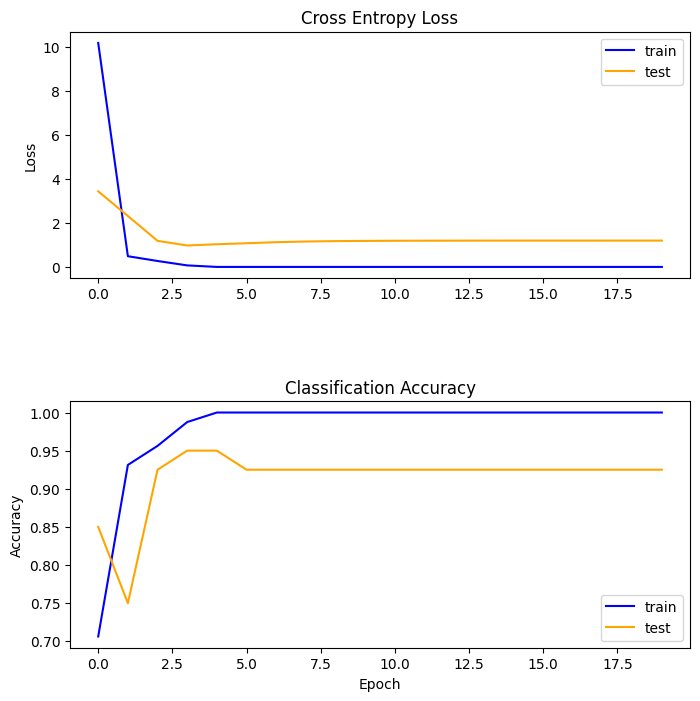

> 92.500


In [17]:
begin_time = time.time()
history4, train_it, test_it = fit_model_evaluate(model_VGG16_TL, train_it_tl, test_it_tl)
end_time = time.time()

# evaluate model
summarize_diagnostics(history4)
# accuracy
_, acc = model_VGG16_TL.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


In [18]:
training_loss=history4.history['loss'][-1]
training_acc=history4.history['accuracy'][-1]
testing_acc=history4.history['val_accuracy'][-1]
number_of_parameters=model_VGG16_TL.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG16TL']['Trainingtime'] = (training_time)
model_data['VGG16TL']['Trainingloss'] = (training_loss)
model_data['VGG16TL']['Trainingaccuracy'] = (training_acc)
model_data['VGG16TL']['Testingaccuracy'] = (testing_acc)
model_data['VGG16TL']['Numberofmodelparameters'] = (number_of_parameters)

print(model_data)


Training Loss:  2.3245570446306374e-07
Training Accuracy:  1.0
Testing Accuracy:  0.925000011920929
Number of Parameters:  17926209
Training Time:  194.35597276687622
{'VGG1': {'Trainingtime': 302.301696062088, 'Trainingloss': 0.32540035247802734, 'Trainingaccuracy': 0.8687499761581421, 'Testingaccuracy': 0.44999998807907104, 'Numberofmodelparameters': 40961153}, 'VGG3': {'Trainingtime': 105.62922811508179, 'Trainingloss': 0.26818832755088806, 'Trainingaccuracy': 0.9437500238418579, 'Testingaccuracy': 0.7250000238418579, 'Numberofmodelparameters': 10333505}, 'VGG3DA': {'Trainingtime': 125.83443188667297, 'Trainingloss': 0.558380126953125, 'Trainingaccuracy': 0.6937500238418579, 'Testingaccuracy': 0.625, 'Numberofmodelparameters': 10333505}, 'VGG16TL': {'Trainingtime': 194.35597276687622, 'Trainingloss': 2.3245570446306374e-07, 'Trainingaccuracy': 1.0, 'Testingaccuracy': 0.925000011920929, 'Numberofmodelparameters': 17926209}}


In [19]:
# summarize model.
model_VGG1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 128)               40960128  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
____________________________________________

In [20]:
model_VGG3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 128)     

In [21]:
model_VGG3_DA.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 128)     

In [22]:
model_VGG16_TL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Convert the dictionary to a dataframe

In [23]:
import pandas as pd
model_data_df = pd.DataFrame(model_data)
pd.options.display.float_format = '{:.2f}'.format

In [24]:
print(model_data)

{'VGG1': {'Trainingtime': 302.301696062088, 'Trainingloss': 0.32540035247802734, 'Trainingaccuracy': 0.8687499761581421, 'Testingaccuracy': 0.44999998807907104, 'Numberofmodelparameters': 40961153}, 'VGG3': {'Trainingtime': 105.62922811508179, 'Trainingloss': 0.26818832755088806, 'Trainingaccuracy': 0.9437500238418579, 'Testingaccuracy': 0.7250000238418579, 'Numberofmodelparameters': 10333505}, 'VGG3DA': {'Trainingtime': 125.83443188667297, 'Trainingloss': 0.558380126953125, 'Trainingaccuracy': 0.6937500238418579, 'Testingaccuracy': 0.625, 'Numberofmodelparameters': 10333505}, 'VGG16TL': {'Trainingtime': 194.35597276687622, 'Trainingloss': 2.3245570446306374e-07, 'Trainingaccuracy': 1.0, 'Testingaccuracy': 0.925000011920929, 'Numberofmodelparameters': 17926209}}


In [25]:
print(model_data_df)

                               VGG1        VGG3      VGG3DA     VGG16TL
Trainingtime                 302.30      105.63      125.83      194.36
Trainingloss                   0.33        0.27        0.56        0.00
Trainingaccuracy               0.87        0.94        0.69        1.00
Testingaccuracy                0.45        0.73        0.62        0.93
Numberofmodelparameters 40961153.00 10333505.00 10333505.00 17926209.00


# Make Predictions and log to tensor board

In [10]:
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(200, 200))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 200, 200, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - np.mean(img)
	return img

In [26]:
import io
import os
import tensorflow as tf

In [36]:
def image_grid(model, log_dir, preprocessor = lambda img: img, img_size=(200, 200)):

	# Get the image locations
	img_folder = 'dataset_Rabbit_vs_Squirrel/test'
	img_files = []
	true_labels = []
	for root, dirs, files in os.walk(img_folder):
		for file in files:
			if file.endswith('.jpg'):
				img_files.append(os.path.join(root, file))
				if file.startswith('Squirrel'):
					true_labels.append(1)
				else:
					true_labels.append(0)
	# Create a figure to contain the plot.
	image_cnt = len(img_files)

	fig, subplots = plt.subplots((image_cnt+4)//5 + 1, 5, figsize=(12, 12))
	plt.tight_layout()
	for i in range(5):
		ax = subplots[0][i]
		ax.axis('off')
	for i, img_file in enumerate(img_files):
		# Getting the prediction
		ax = subplots[i//5 +1, i%5]
		img = load_img(img_file, target_size=img_size)
		processed_img = preprocessor(np.array(img))
		predicted_label = round(model.predict(tf.expand_dims(processed_img, axis=0))[0][0])
		true_label = true_labels[i]
		ax.set_title(f"PL: {predicted_label}\nTL: {true_label}")
		ax.axis('off')
		ax.imshow(img, cmap=plt.cm.binary)

	buf = io.BytesIO()
	plt.savefig(buf, format='png')
	# Closing the figure prevents it from being displayed directly inside
	# the notebook.
	plt.close(fig)
	buf.seek(0)
	# Convert PNG buffer to TF image
	image = tf.image.decode_png(buf.getvalue(), channels=4)
	# Add the batch dimension
	image = tf.expand_dims(image, 0)
	# Getting the writer
	file_writer = tf.summary.create_file_writer(log_dir)
	with file_writer.as_default():
		tf.summary.image("Training data", image, step=0)

	return fig

1/1 [==============================] - 0s 14ms/step


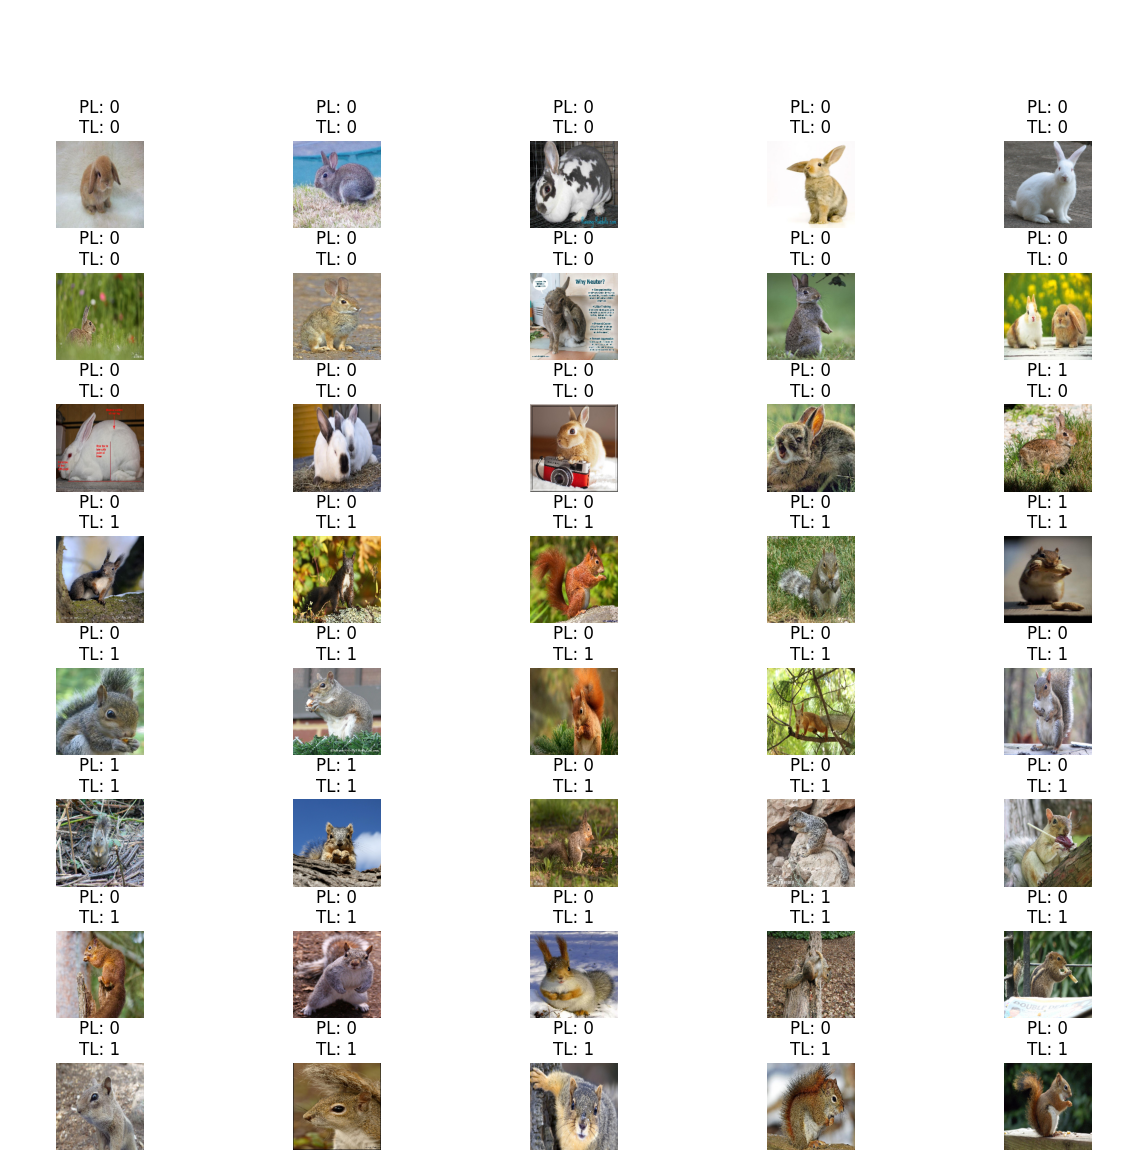

In [37]:
image_grid(model_VGG1, 'logs/VGG1/plots')

1/1 [==============================] - 0s 15ms/step


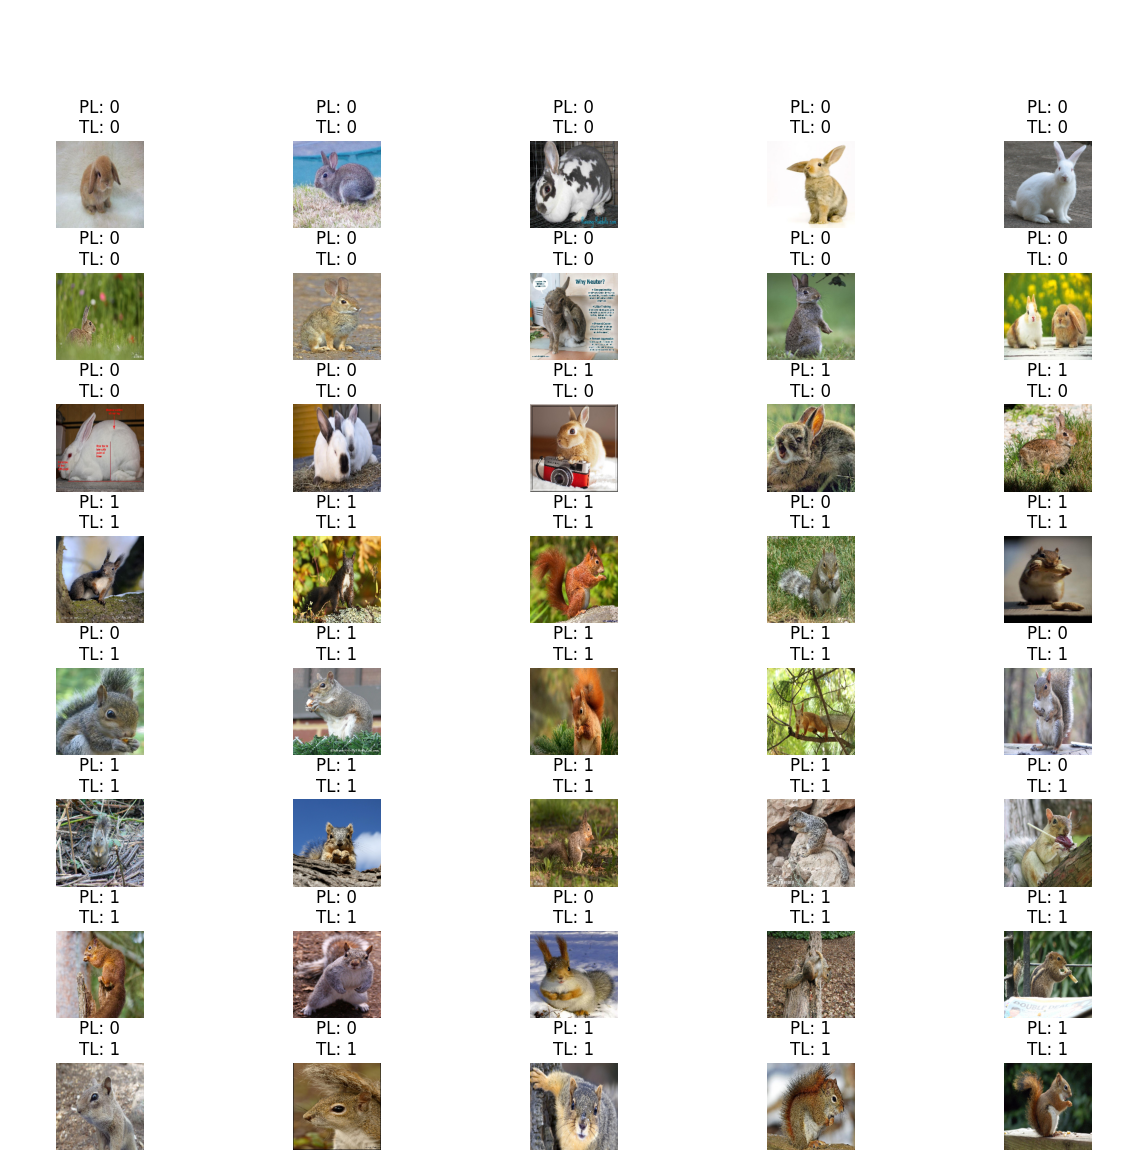

In [38]:
image_grid(model_VGG3, 'logs/VGG3/plots')


1/1 [==============================] - 0s 14ms/step


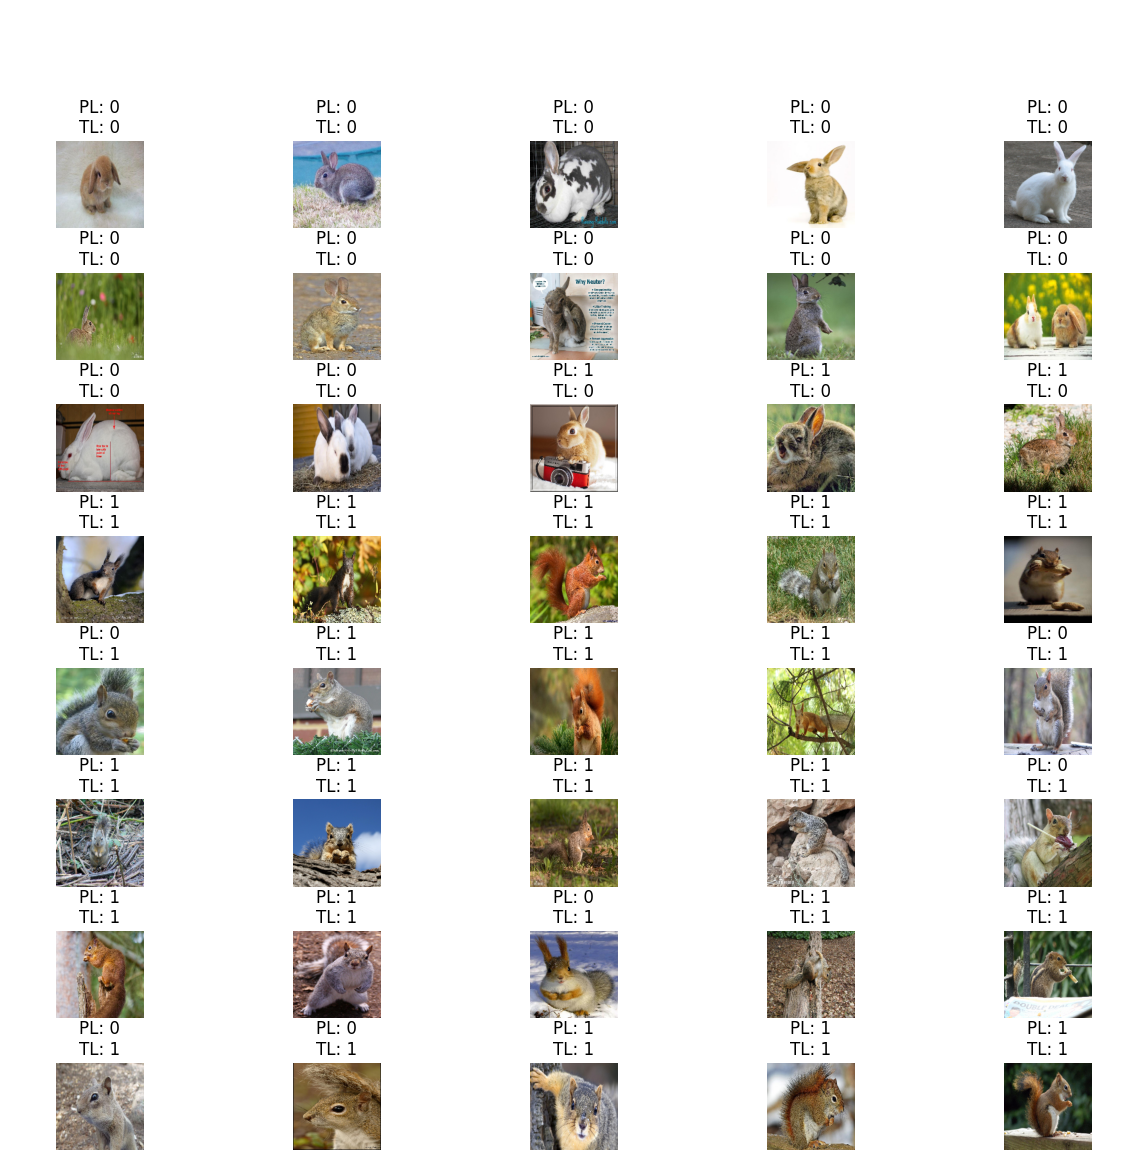

In [39]:
image_grid(model_VGG3_DA, 'logs/VGG3_DA/plots')


In [40]:
# VGG16 preprocessor
def preprocess_input_VGG16(img):
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

1/1 [==============================] - 0s 17ms/step


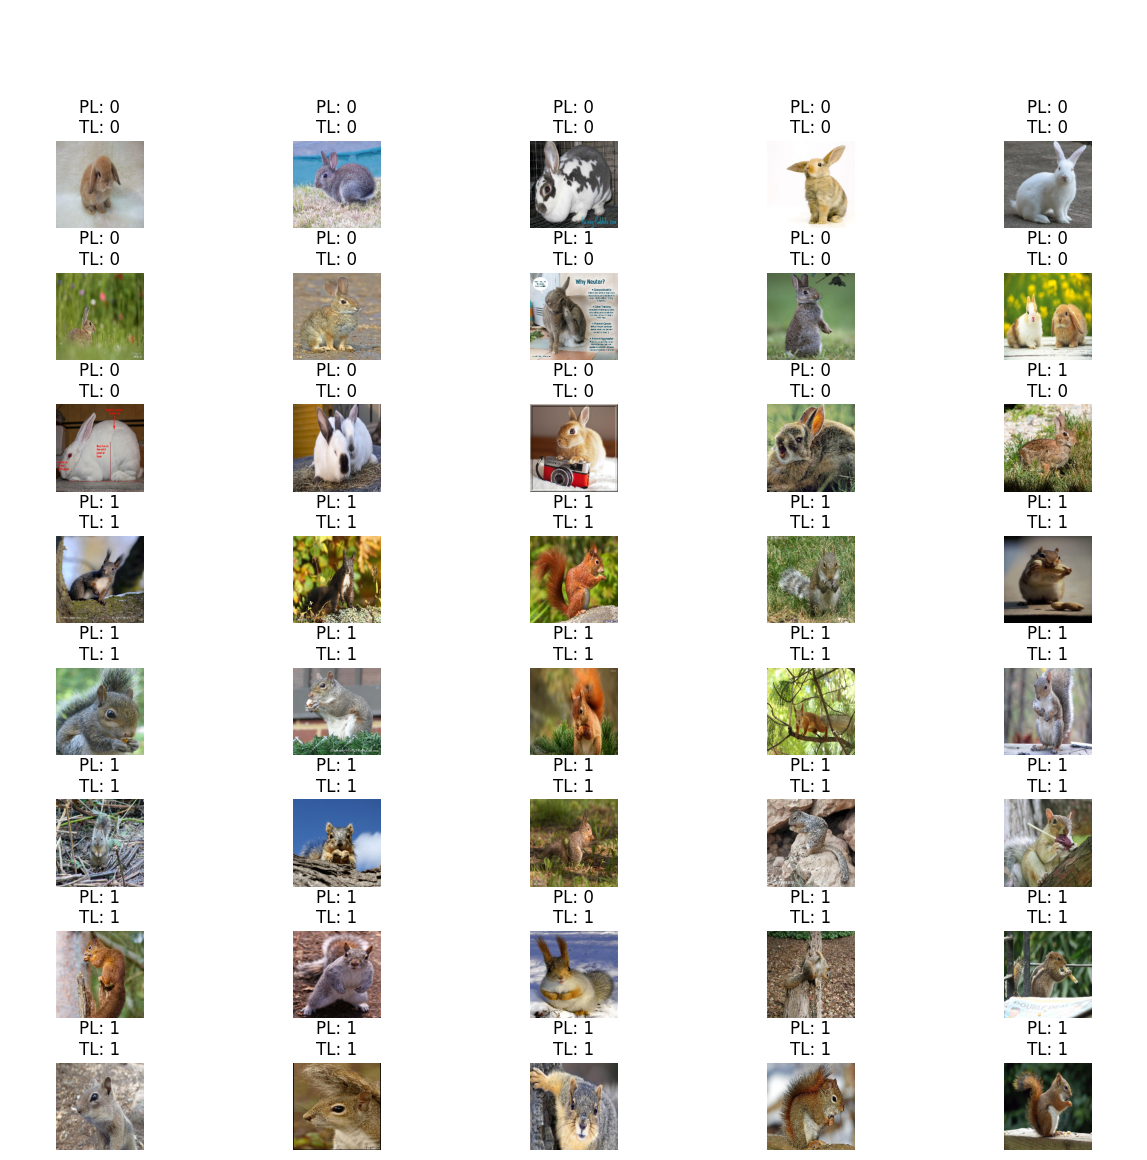

In [41]:
image_grid(model_VGG16_TL, 'logs/VGG16_TL/plots', preprocess_input_VGG16, img_size=(224, 224))